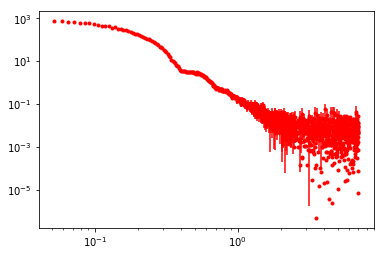

Figure 1: data


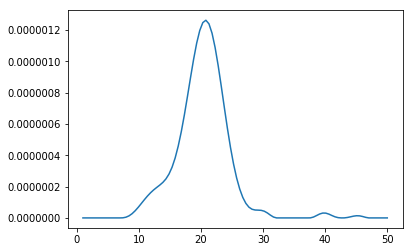

Figure 2: particle size distribution


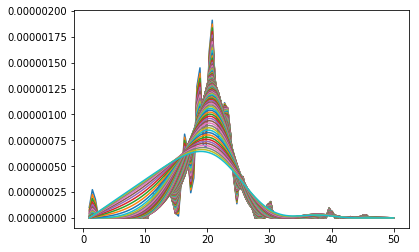

Figure 3: all distributions


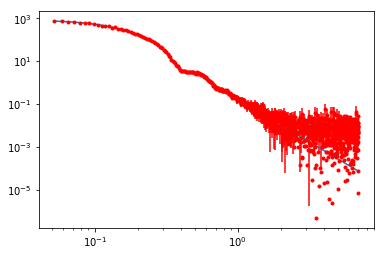

Figure 4: data (red points) and fit (blue line)


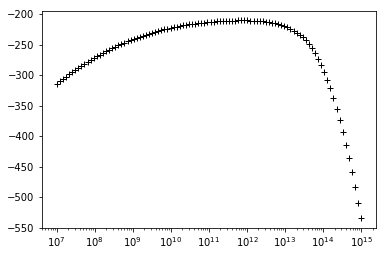

Figure 5: evidence vs alpha


In [2]:
# In this notebook the particle size distribution is extracted from 
# the small-angle scattering data (here SAXS, but could be also SANS) of a nanoparticle sample
# by a regularized numerical inversion under assumption of spherical particle shape.
# The results (using basically the identical code) are published in: 
# "Distribution functions of magnetic nanoparticles determined by a numerical inversion method"
# https://doi.org/10.1088/1367-2630/aa73b4

#==============================================================================
# import of packages
from numpy.linalg import slogdet
import numpy as np
import pylab as py
from scipy.optimize import nnls
#==============================================================================
# data import
q,Iq,sd=np.genfromtxt("../data/SC-SAXS_data.txt",unpack=True,skip_header=0,skip_footer=0,usecols=(0,1,2))

Nq=len(q)

sd_sq   = pow(sd,2)       
sdnorm  = 1/sd 
sdnorm = Nq * sdnorm/sdnorm.sum()
sdmat = np.diag(sdnorm)
sdcol  = sdnorm[:,np.newaxis]            

I = Iq.dot(sdmat) # normalize data by sigma

qfit=np.logspace(-2,1,100)

#==============================================================================
# generate list for regularization parameter a and particle size/diameter

N=100 
dcList=np.linspace(1.,50.,N)

Na=100
aList=np.logspace(7.,15,Na) # regularization parameter

#==============================================================================
# Plot data

py.errorbar(q,Iq,sd,color='r',marker='.',ls='None',label='Observed')
py.xscale('log')
py.yscale('log')
py.show()
print('Figure 1: data')   

#==============================================================================
# regularization matrix

L=0.5*(-1*np.eye(N,k=-1)+2*np.eye(N,k=0)-1*np.eye(N,k=1))
L[0,1] = 0
L[N-1,N-2] = 0

#==============================================================================
# Definition of function to generate the system matrix

def Aij(q,dc): # defintion of model function for transfer matrix (form factor of a sphere)
    y=pow(0.5*np.pi*pow(dc,3)*(np.sin(q*dc/2.)-q*dc/2.*np.cos(q*dc/2.))/(pow(q*dc/2.,3)),2)
    return y  

#==============================================================================
# Inversion of data

evList=[] 
prList=[]

X = np.hstack([I, np.zeros(N)]) 
qmat=np.tile(q,(N,1)).T

dcmat=np.tile(dcList,(Nq,1))


K = Aij(qmat, dcmat) # Transfer matrix is determined
K = np.asarray(K)

for ai in range(len(aList)):
    # stacking of matrices            
    C = np.vstack([K*sdcol,np.sqrt(aList[ai])*L]) 
    X = np.hstack([I, np.zeros(N)]) 
    B = (K.T).dot(K*pow(sdcol,2))            
    
    # Fit: 
    pr, resnorm = nnls(C,X) # least-square fit with non-negative constraint
    
    # determine chisquare            
    Ifit=K.dot(pr)    
    chisq=(pow(Iq-Ifit,2)/sd_sq).sum()               

    # calculation of evidence 
    S=sum(pow(L.dot(pr),2))
    Lsq=pow(L,2)                   
    U=2*Lsq+B/aList[ai] 
    detsign,rlogdet=slogdet(U)
    G=-aList[ai]*S-0.5*chisq        
    evidence=(G-0.5*rlogdet) # log of evidence
    
    evList.append(evidence)            
    prList.append(pr)

MAX=evList.index(max(evList)) # find maximal evidence
prM=prList[MAX]

prList2=np.reshape(prList,(Na,N))         

IfitM=K.dot(prM)  

#==============================================================================
# plots 

py.plot(dcList,prM)
py.show()   
print('Figure 2: particle size distribution')

py.figure()
for i in range(Na):
    py.plot(dcList,prList2[i,:])
py.show() 
print('Figure 3: all distributions')

py.errorbar(q,Iq,sd,color='r',marker='.',ls='None',label='Observed')
py.loglog(q,IfitM)
py.show() 
print('Figure 4: data (red points) and fit (blue line)')

py.plot(aList,evList,'k+')
py.xscale('log')
py.show()
print('Figure 5: evidence vs alpha')